# Assignment 2 — Task 2: Feature Map Visualization
**This notebook is standalone.** It will:
1. Re-train the same CNN from Task 1 on CIFAR-10
2. Run Part A: Feature maps from the first conv layer
3. Run Part B: Maximally activating images for 3 selected filters

> **Colab tip:** Go to `Runtime → Change runtime type → T4 GPU` before running.

---
## Step 1 — Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f'TensorFlow version : {tf.__version__}')
print(f'GPU available      : {len(tf.config.list_physical_devices("GPU")) > 0}')

TensorFlow version : 2.19.0
GPU available      : True


---
## Step 2 — Load & Preprocess CIFAR-10

In [16]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0
y_train = y_train.flatten()
y_test  = y_test.flatten()

val_split = int(0.1 * len(x_train))
x_val,   y_val   = x_train[:val_split], y_train[:val_split]
x_train, y_train = x_train[val_split:], y_train[val_split:]

print(f'Train: {x_train.shape[0]} | Val: {x_val.shape[0]} | Test: {x_test.shape[0]}')

Train: 45000 | Val: 5000 | Test: 10000


---
## Step 3 — Build & Train CNN
*(Same architecture as Task 1 — must be trained to get meaningful visualizations)*

In [17]:
def build_cnn(input_shape=(32, 32, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape, name='input')

    # Block 1
    x = layers.Conv2D(32, (3,3), padding='same', name='conv1_1')(inputs)
    x = layers.BatchNormalization(name='bn1_1')(x)
    x = layers.Activation('relu', name='relu1_1')(x)   # ← first conv layer output
    x = layers.Conv2D(32, (3,3), padding='same', name='conv1_2')(x)
    x = layers.BatchNormalization(name='bn1_2')(x)
    x = layers.Activation('relu', name='relu1_2')(x)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    x = layers.Dropout(0.25, name='drop1')(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), padding='same', name='conv2_1')(x)
    x = layers.BatchNormalization(name='bn2_1')(x)
    x = layers.Activation('relu', name='relu2_1')(x)
    x = layers.Conv2D(64, (3,3), padding='same', name='conv2_2')(x)
    x = layers.BatchNormalization(name='bn2_2')(x)
    x = layers.Activation('relu', name='relu2_2')(x)   # ← middle layer for Part B
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    x = layers.Dropout(0.25, name='drop2')(x)

    # Block 3
    x = layers.Conv2D(128, (3,3), padding='same', name='conv3_1')(x)
    x = layers.BatchNormalization(name='bn3_1')(x)
    x = layers.Activation('relu', name='relu3_1')(x)
    x = layers.Conv2D(128, (3,3), padding='same', name='conv3_2')(x)
    x = layers.BatchNormalization(name='bn3_2')(x)
    x = layers.Activation('relu', name='relu3_2')(x)
    x = layers.MaxPooling2D((2,2), name='pool3')(x)
    x = layers.Dropout(0.25, name='drop3')(x)

    # Classification head
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(256, name='fc1')(x)
    x = layers.BatchNormalization(name='bn_fc')(x)
    x = layers.Activation('relu', name='relu_fc')(x)
    x = layers.Dropout(0.5, name='drop_fc')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

    return keras.Model(inputs, outputs, name='CIFAR10_CNN')

model = build_cnn()

datagen = ImageDataGenerator(
    horizontal_flip=True, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=15, zoom_range=0.1
)
datagen.fit(x_train)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

print('Training CNN — this takes ~10 min on GPU...')
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    steps_per_epoch=len(x_train) // 64,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'\nTest Accuracy: {test_acc*100:.2f}%  |  Test Loss: {test_loss:.4f}')

Training CNN — this takes ~10 min on GPU...
Epoch 1/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.3324 - loss: 1.9307 - val_accuracy: 0.4796 - val_loss: 1.4669 - learning_rate: 0.0010
Epoch 2/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.5469 - loss: 1.2476 - val_accuracy: 0.4952 - val_loss: 1.4232 - learning_rate: 0.0010
Epoch 3/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.5408 - loss: 1.2825 - val_accuracy: 0.5716 - val_loss: 1.2307 - learning_rate: 0.0010
Epoch 4/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.4688 - loss: 1.5669 - val_accuracy: 0.5586 - val_loss: 1.3081 - learning_rate: 0.0010
Epoch 5/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.6109 - loss: 1.0968 - val_accuracy: 0.6412 - val_loss: 1.0233 - learning_rate: 0.0010
Epoch 6/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.6094 - loss: 0.9723 - val_accuracy: 0.6422 - val_loss: 1.0003 - learning_rate: 0.0010
Epoch 7/50
703/703 ━━━━━━━━━━━━━

---
## TASK 2 — Part A: Feature Maps from the First Convolutional Layer

### Step 4 — Select 3 Test Images from Different Classes

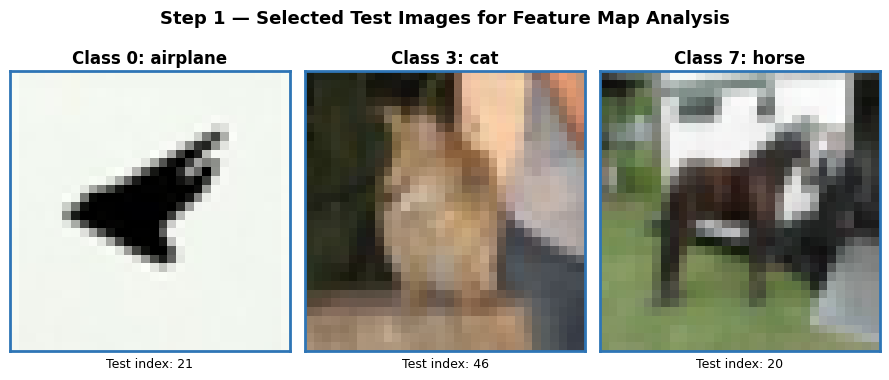

Saved: selected_images.png


In [18]:
# ── Pick 3 classes: airplane (0), cat (3), horse (7) ─────────────────────
TARGET_CLASSES = [0, 3, 7]

selected_images = []
selected_labels = []
selected_indices = []

for cls in TARGET_CLASSES:
    idx = np.where(y_test == cls)[0][2]   # pick 3rd example to get a clear image
    selected_images.append(x_test[idx])
    selected_labels.append(y_test[idx])
    selected_indices.append(idx)

selected_images = np.array(selected_images)  # (3, 32, 32, 3)

# Display selected images
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
for i, (img, lbl) in enumerate(zip(selected_images, selected_labels)):
    axes[i].imshow(img)
    axes[i].set_title(f'Class {lbl}: {CLASS_NAMES[lbl]}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(f'Test index: {selected_indices[i]}', fontsize=9)
    axes[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in axes[i].spines.values():
        spine.set_edgecolor('#2E75B6')
        spine.set_linewidth(2)

plt.suptitle('Step 1 — Selected Test Images for Feature Map Analysis', fontsize=13, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('selected_images.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: selected_images.png')

### Step 5 — Extract Feature Maps from Layer `relu1_1` (First Conv Layer)

In [19]:
# Build sub-model: input → relu1_1 output
# relu1_1 is the ReLU activation AFTER the first Conv2D + BatchNorm
feature_map_model = keras.Model(
    inputs=model.input,
    outputs=model.get_layer('relu1_1').output,
    name='FeatureMapExtractor'
)

feature_maps = feature_map_model.predict(selected_images, verbose=0)
# Shape: (3 images, 32 height, 32 width, 32 channels)

print(f'Feature map shape : {feature_maps.shape}')
print(f'  → {feature_maps.shape[0]} images')
print(f'  → {feature_maps.shape[1]}x{feature_maps.shape[2]} spatial resolution')
print(f'  → {feature_maps.shape[3]} filters / channels')
print(f'\nActivation stats (all 3 images):')
print(f'  Min  : {feature_maps.min():.4f}')
print(f'  Max  : {feature_maps.max():.4f}')
print(f'  Mean : {feature_maps.mean():.4f}')
print(f'  % zero (ReLU-suppressed): {(feature_maps == 0).mean()*100:.1f}%')

Feature map shape : (3, 32, 32, 32)
  → 3 images
  → 32x32 spatial resolution
  → 32 filters / channels

Activation stats (all 3 images):
  Min  : 0.0000
  Max  : 12.9964
  Mean : 0.4621
  % zero (ReLU-suppressed): 41.6%


### Step 6 — Visualize Feature Maps: 8 Filters per Image

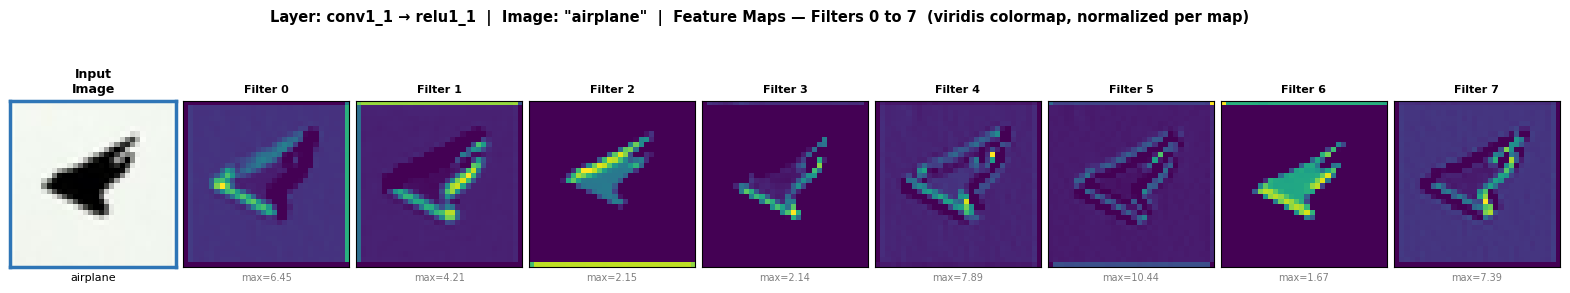

Saved: feature_maps_airplane.png


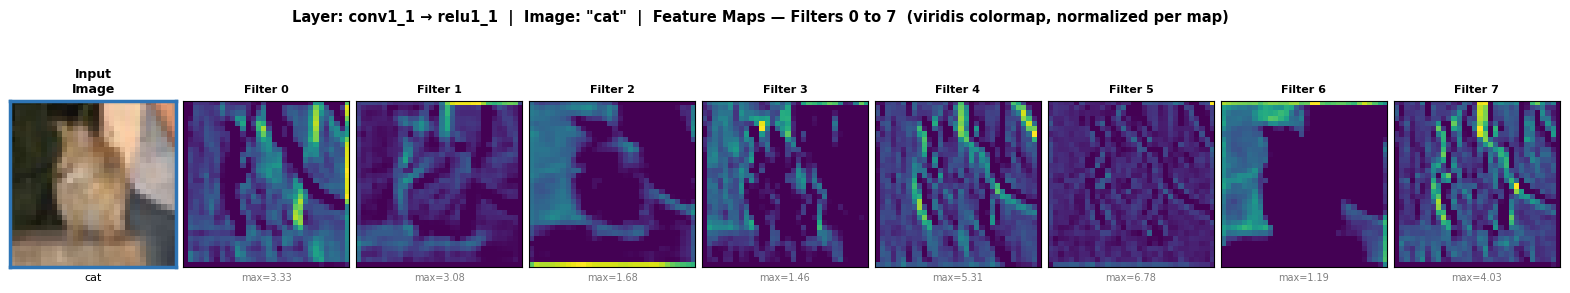

Saved: feature_maps_cat.png


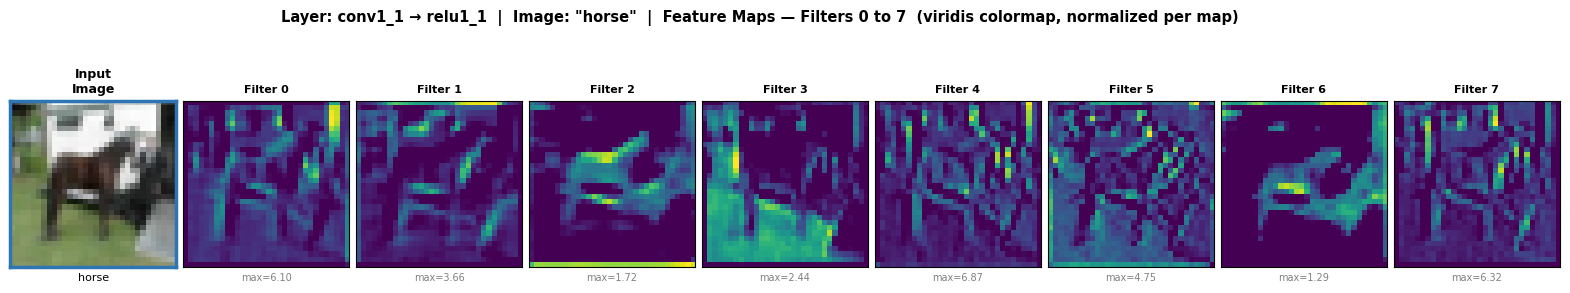

Saved: feature_maps_horse.png


In [20]:
NUM_FILTERS = 8
LAYER_NAME  = 'conv1_1 → relu1_1'

for img_idx in range(3):
    class_name = CLASS_NAMES[selected_labels[img_idx]]
    fmaps = feature_maps[img_idx]   # (32, 32, 32)

    fig = plt.figure(figsize=(20, 3.2))
    gs  = gridspec.GridSpec(1, NUM_FILTERS + 1,
                            figure=fig, wspace=0.04)

    # ── Original image ────────────────────────────────────
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(selected_images[img_idx])
    ax0.set_title('Input\nImage', fontsize=9, fontweight='bold')
    ax0.set_xlabel(f'{CLASS_NAMES[selected_labels[img_idx]]}', fontsize=8)
    ax0.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in ax0.spines.values():
        spine.set_edgecolor('#2E75B6')
        spine.set_linewidth(2.5)

    # ── Feature maps (filters 0-7) ────────────────────────
    for f in range(NUM_FILTERS):
        ax = fig.add_subplot(gs[0, f + 1])
        fm = fmaps[:, :, f]

        # Normalize each map to [0,1] for visibility
        fm_min, fm_max = fm.min(), fm.max()
        fm_norm = (fm - fm_min) / (fm_max - fm_min + 1e-8)

        ax.imshow(fm_norm, cmap='viridis')
        ax.set_title(f'Filter {f}', fontsize=8, fontweight='bold')
        ax.set_xlabel(f'max={fm_max:.2f}', fontsize=7, color='gray')
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    fig.suptitle(
        f'Layer: {LAYER_NAME}  |  Image: "{class_name}"  |  '
        f'Feature Maps — Filters 0 to {NUM_FILTERS-1}  (viridis colormap, normalized per map)',
        fontsize=10.5, fontweight='bold', y=1.04
    )
    fname = f'feature_maps_{class_name}.png'
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {fname}')

### Step 7 — Show All 32 Feature Maps in a Grid (Extended View)

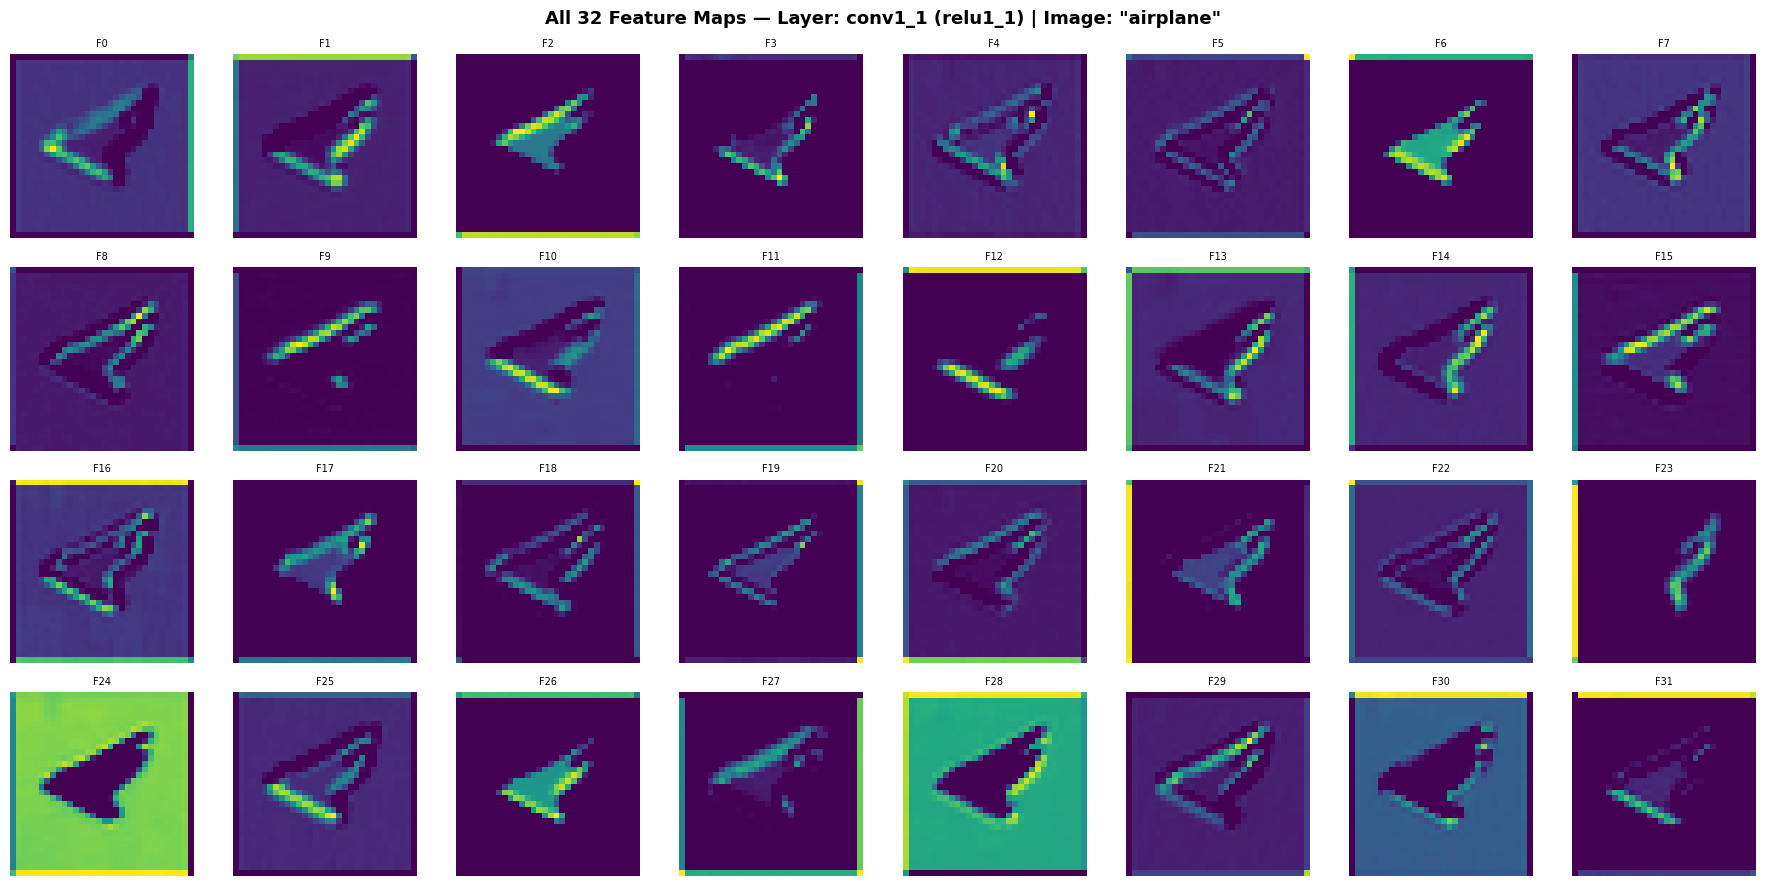

Saved: all_feature_maps_airplane.png


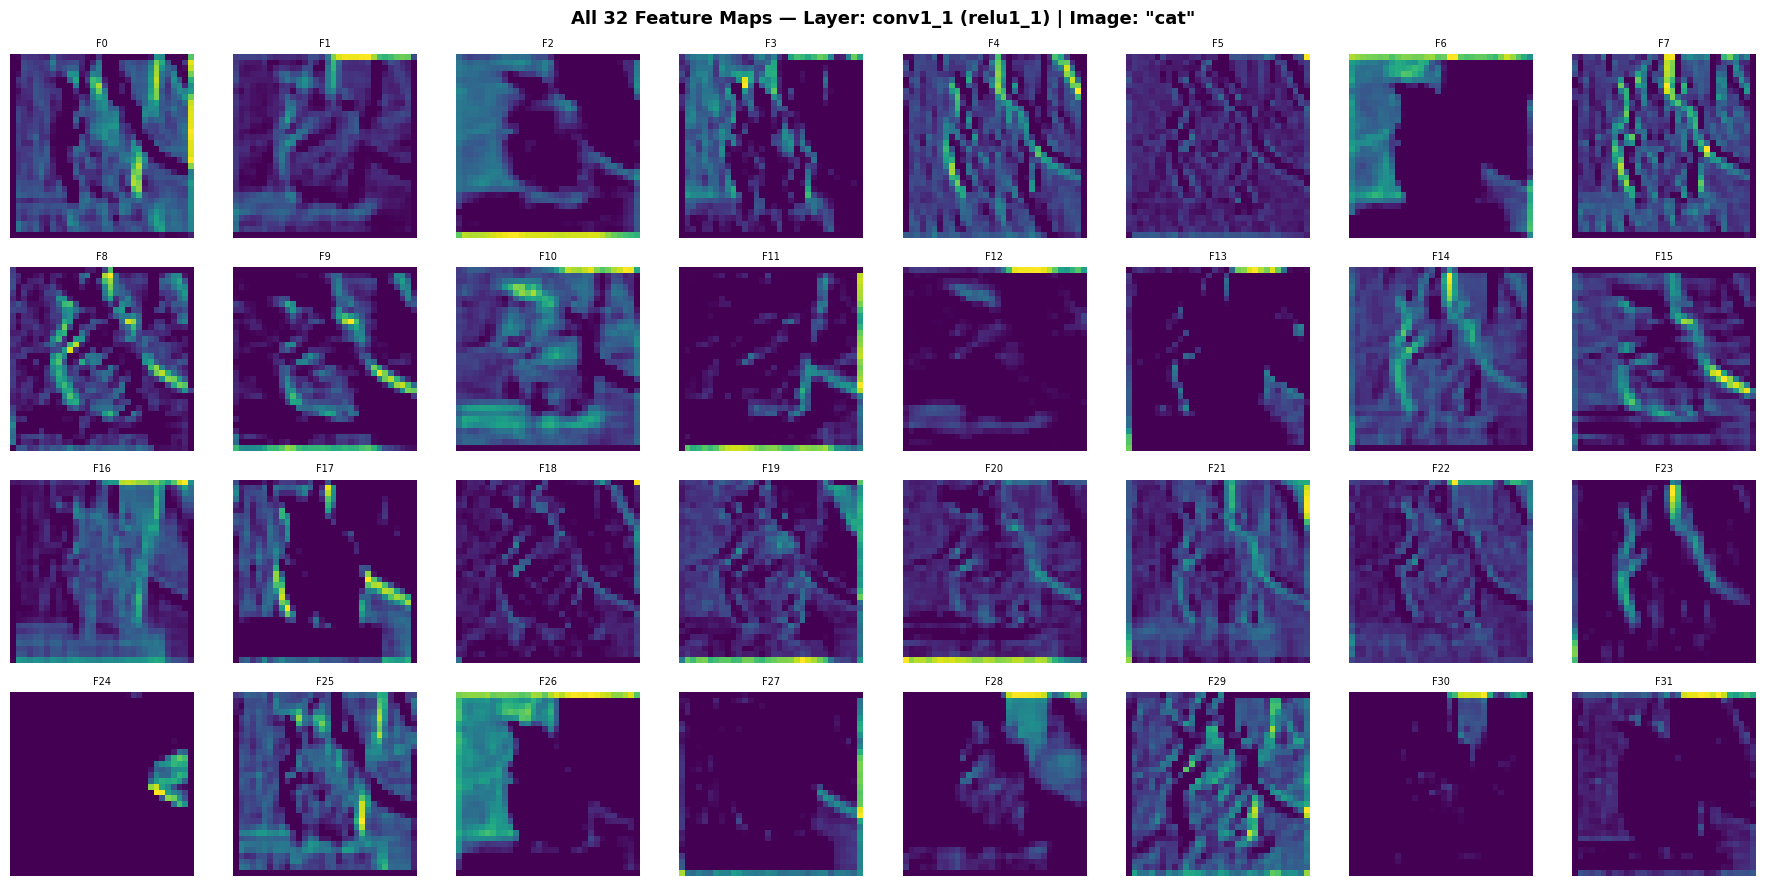

Saved: all_feature_maps_cat.png


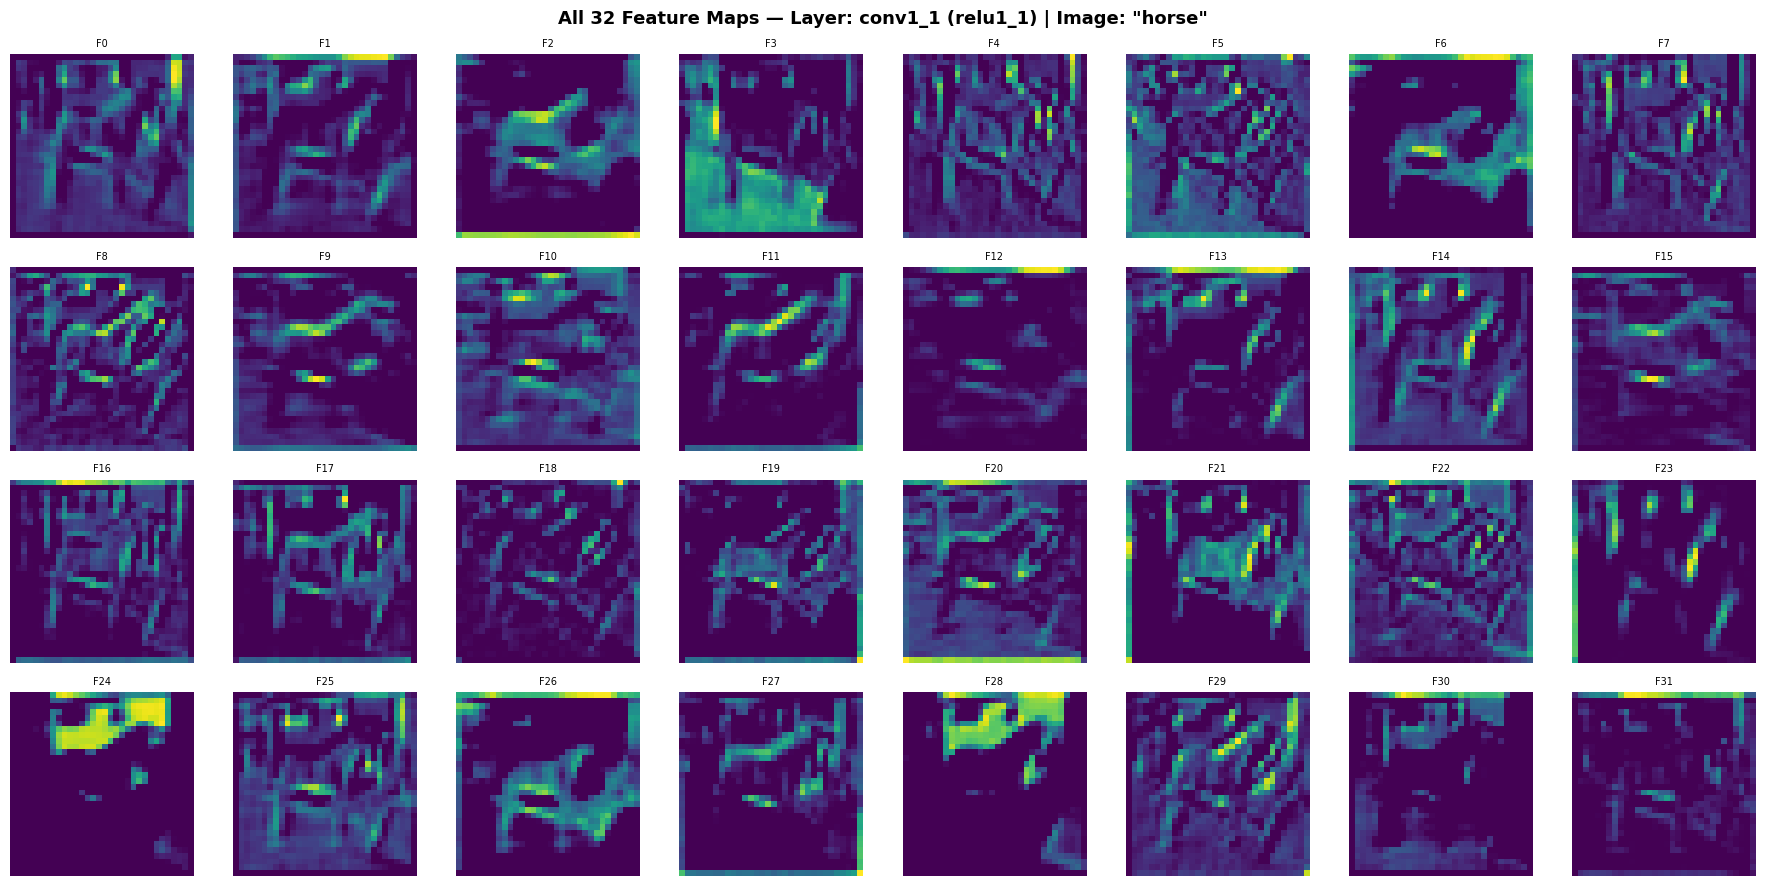

Saved: all_feature_maps_horse.png


In [21]:
# Show all 32 filters for all 3 images side by side in one big grid
for img_idx in range(3):
    class_name = CLASS_NAMES[selected_labels[img_idx]]
    fmaps = feature_maps[img_idx]  # (32, 32, 32)

    fig, axes = plt.subplots(4, 8, figsize=(18, 9))
    for f in range(32):
        ax  = axes[f // 8, f % 8]
        fm  = fmaps[:, :, f]
        fm_norm = (fm - fm.min()) / (fm.max() - fm.min() + 1e-8)
        ax.imshow(fm_norm, cmap='viridis')
        ax.set_title(f'F{f}', fontsize=7)
        ax.axis('off')

    fig.suptitle(
        f'All 32 Feature Maps — Layer: conv1_1 (relu1_1) | Image: "{class_name}"',
        fontsize=13, fontweight='bold'
    )
    plt.tight_layout()
    fname = f'all_feature_maps_{class_name}.png'
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {fname}')

### Step 8 — Visualize Learned Filter Kernels (What the Filters Look Like)

conv1_1 kernel shape: (3, 3, 3, 32)


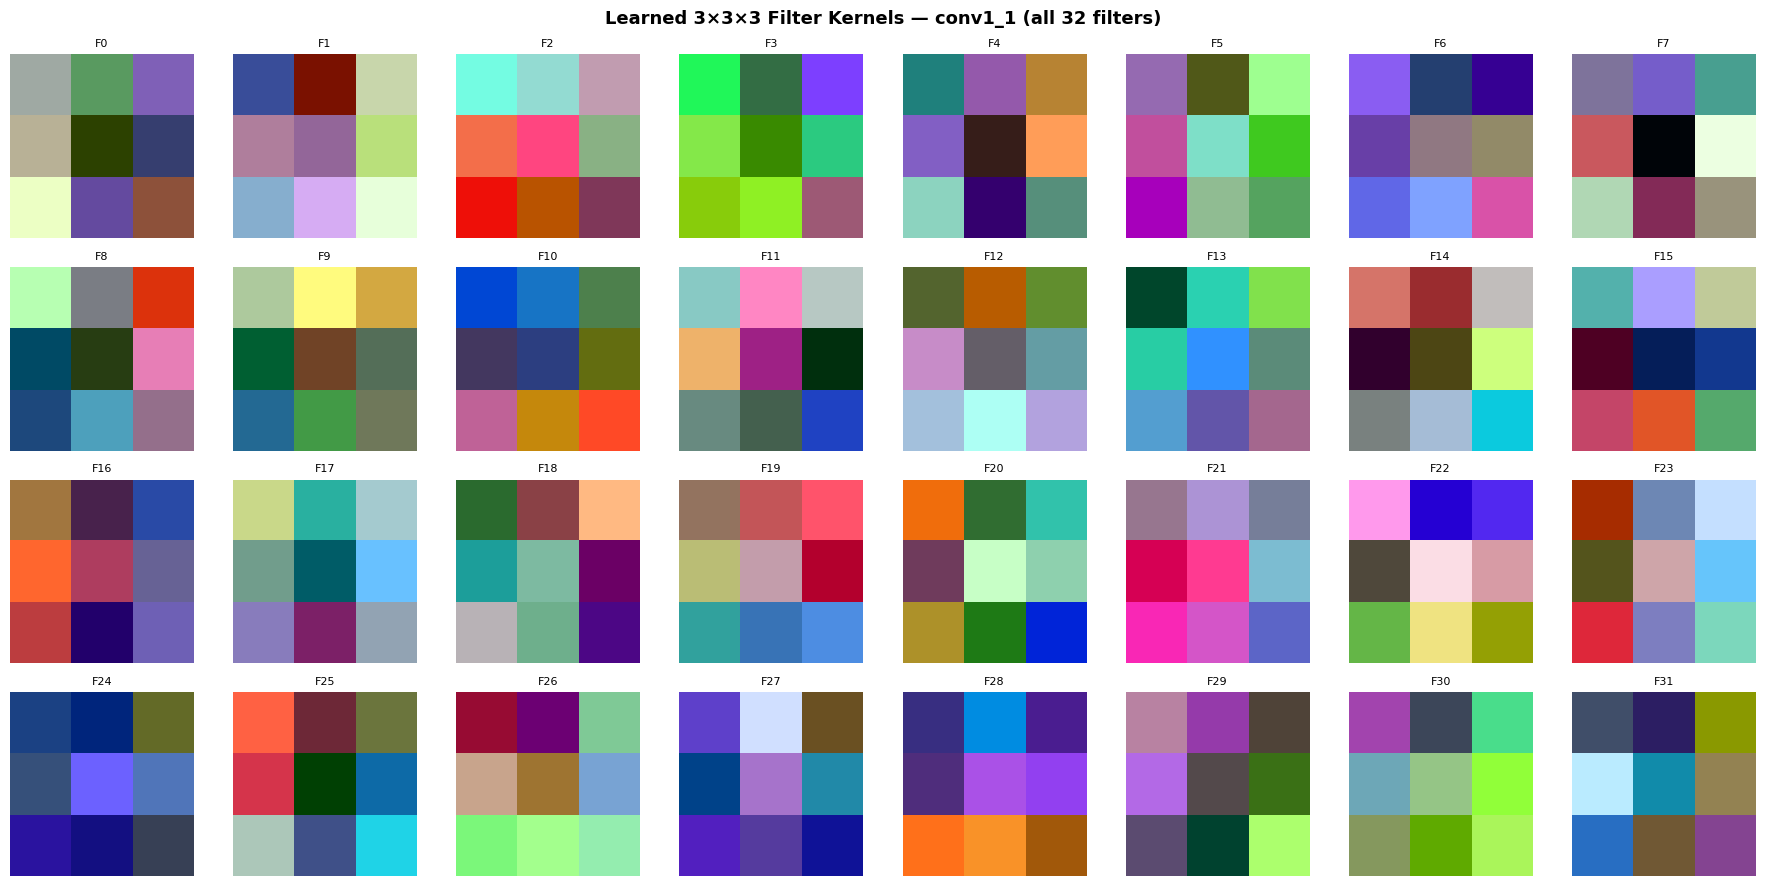

Saved: conv1_filter_kernels.png


In [22]:
# Extract learned conv1_1 kernel weights
# Shape: (kernel_h, kernel_w, in_channels, out_filters) = (3, 3, 3, 32)
conv1_weights = model.get_layer('conv1_1').get_weights()[0]
print(f'conv1_1 kernel shape: {conv1_weights.shape}')

fig, axes = plt.subplots(4, 8, figsize=(18, 9))
for f in range(32):
    ax     = axes[f // 8, f % 8]
    kernel = conv1_weights[:, :, :, f]     # (3, 3, 3) — RGB filter
    # Normalize to [0, 1] for display
    k_norm = (kernel - kernel.min()) / (kernel.max() - kernel.min() + 1e-8)
    ax.imshow(k_norm)
    ax.set_title(f'F{f}', fontsize=8)
    ax.axis('off')

fig.suptitle('Learned 3×3×3 Filter Kernels — conv1_1 (all 32 filters)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('conv1_filter_kernels.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: conv1_filter_kernels.png')

---
## TASK 2 — Part B: Maximally Activating Images

### Step 9 — Setup: Choose Layer & Filters

In [23]:
# ── Configuration ──────────────────────────────────────────────────────────
CHOSEN_LAYER   = 'relu2_2'     # Middle layer — Block 2, 2nd conv activation
CHOSEN_FILTERS = [0, 10, 25]   # 3 filters to analyze
TOP_K          = 5             # top-N images per filter

# Activation definition: MEAN of the 2D feature map (overall response strength)
# Alternative would be MAX (strongest local response) — we use MEAN
ACTIVATION_METHOD = 'mean'

print(f'Layer            : {CHOSEN_LAYER}')
print(f'Chosen filters   : {CHOSEN_FILTERS}')
print(f'Activation metric: {ACTIVATION_METHOD} of the 2D feature map')
print(f'Top-K images     : {TOP_K}')
print()
print('Rationale for MEAN:')
print('  Mean activation captures how consistently a filter fires across the')
print('  entire image, not just at one hot spot. This gives a better measure')
print('  of which images globally contain the feature a filter responds to.')

Layer            : relu2_2
Chosen filters   : [0, 10, 25]
Activation metric: mean of the 2D feature map
Top-K images     : 5

Rationale for MEAN:
  Mean activation captures how consistently a filter fires across the
  entire image, not just at one hot spot. This gives a better measure
  of which images globally contain the feature a filter responds to.


### Step 10 — Compute Activations for All 10,000 Test Images

In [24]:
# Build activation sub-model
activation_model = keras.Model(
    inputs=model.input,
    outputs=model.get_layer(CHOSEN_LAYER).output,
    name='ActivationExtractor'
)

print(f'Running all {len(x_test):,} test images through {CHOSEN_LAYER}...')

BATCH = 256
all_activations = []

for start in range(0, len(x_test), BATCH):
    batch = x_test[start:start + BATCH]
    act   = activation_model.predict(batch, verbose=0)   # (B, 16, 16, 64)
    all_activations.append(act)

all_activations = np.concatenate(all_activations, axis=0)  # (10000, 16, 16, 64)
print(f'Activation tensor shape: {all_activations.shape}')

# Reduce 2D feature map → scalar per filter using MEAN over spatial dims
if ACTIVATION_METHOD == 'mean':
    scalar_activations = all_activations.mean(axis=(1, 2))  # (10000, 64)
else:
    scalar_activations = all_activations.max(axis=(1, 2))   # (10000, 64)

print(f'Scalar activations shape : {scalar_activations.shape}')
print(f'Activation method used   : {ACTIVATION_METHOD}')

Running all 10,000 test images through relu2_2...
Activation tensor shape: (10000, 16, 16, 64)
Scalar activations shape : (10000, 64)
Activation method used   : mean


### Step 11 — Visualize Top-5 Images per Filter

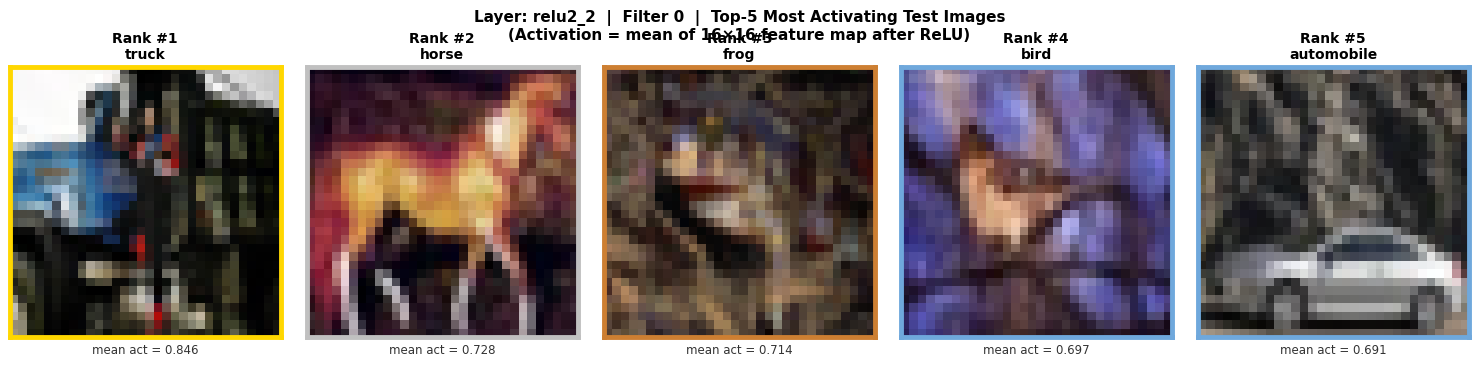

Filter 0: classes  = ['truck', 'horse', 'frog', 'bird', 'automobile']
          scores   = ['0.846', '0.728', '0.714', '0.697', '0.691']
Saved: max_activating_filter0.png



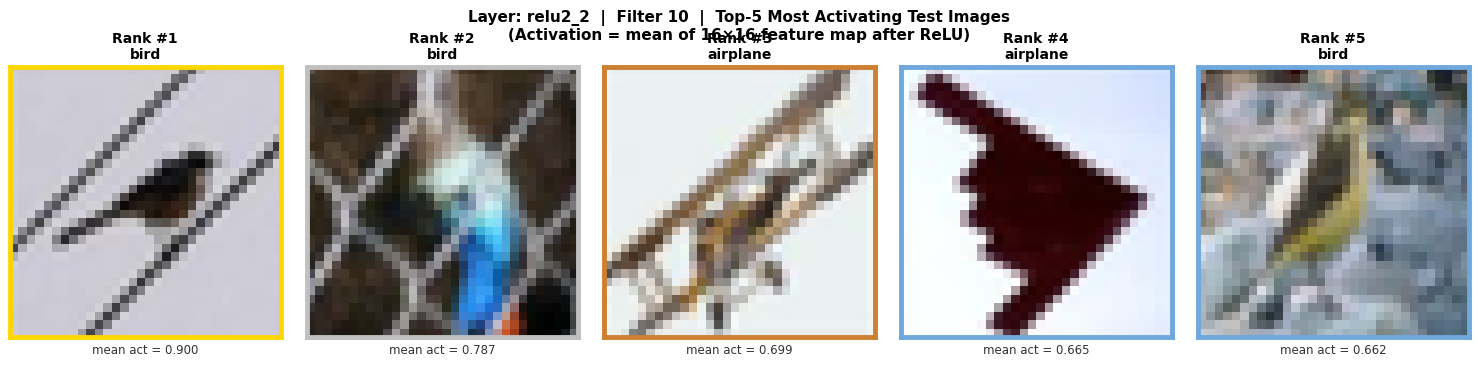

Filter 10: classes  = ['bird', 'bird', 'airplane', 'airplane', 'bird']
          scores   = ['0.900', '0.787', '0.699', '0.665', '0.662']
Saved: max_activating_filter10.png



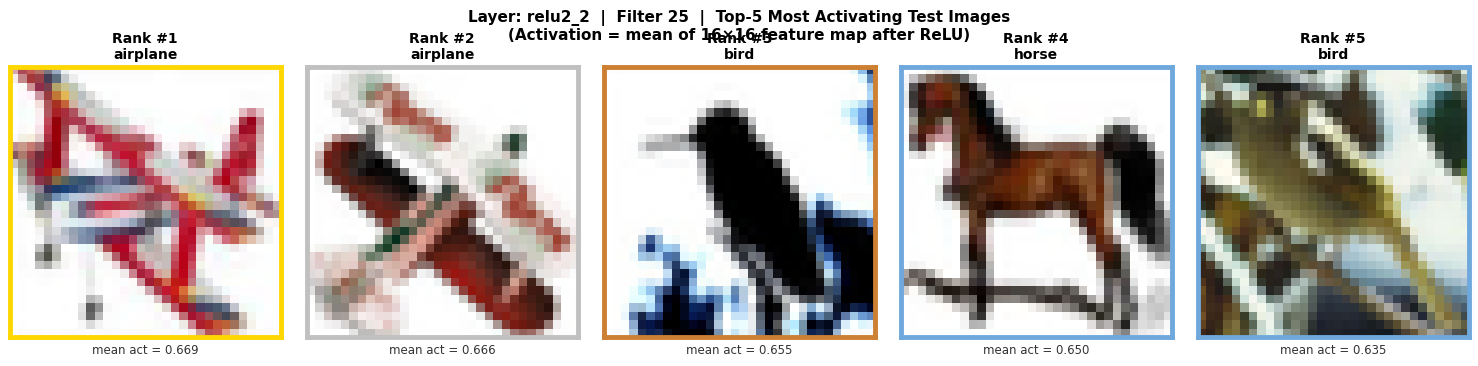

Filter 25: classes  = ['airplane', 'airplane', 'bird', 'horse', 'bird']
          scores   = ['0.669', '0.666', '0.655', '0.650', '0.635']
Saved: max_activating_filter25.png



In [25]:
rank_colors = ['#FFD700', '#C0C0C0', '#CD7F32', '#6FA8DC', '#6FA8DC']  # gold, silver, bronze, blue, blue

for filt_idx in CHOSEN_FILTERS:
    filter_scores = scalar_activations[:, filt_idx]        # (10000,)
    top5_indices  = np.argsort(filter_scores)[::-1][:TOP_K]
    top5_scores   = filter_scores[top5_indices]
    top5_labels   = y_test[top5_indices]
    top5_classes  = [CLASS_NAMES[l] for l in top5_labels]

    fig, axes = plt.subplots(1, TOP_K, figsize=(15, 3.5))
    for rank, (img_idx, score, label, cname) in enumerate(
            zip(top5_indices, top5_scores, top5_labels, top5_classes)):

        axes[rank].imshow(x_test[img_idx])
        axes[rank].set_title(
            f'Rank #{rank+1}\n{cname}',
            fontsize=10, fontweight='bold'
        )
        axes[rank].set_xlabel(
            f'{ACTIVATION_METHOD} act = {score:.3f}',
            fontsize=8.5, color='#333333'
        )
        axes[rank].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        for spine in axes[rank].spines.values():
            spine.set_edgecolor(rank_colors[rank])
            spine.set_linewidth(3.5)

    fig.suptitle(
        f'Layer: {CHOSEN_LAYER}  |  Filter {filt_idx}  |  '
        f'Top-{TOP_K} Most Activating Test Images\n'
        f'(Activation = {ACTIVATION_METHOD} of 16×16 feature map after ReLU)',
        fontsize=11, fontweight='bold'
    )
    plt.tight_layout()
    fname = f'max_activating_filter{filt_idx}.png'
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()

    print(f'Filter {filt_idx}: classes  = {top5_classes}')
    print(f'          scores   = {[f"{s:.3f}" for s in top5_scores]}')
    print(f'Saved: {fname}\n')

### Step 12 — Per-Class Average Activation Heatmap

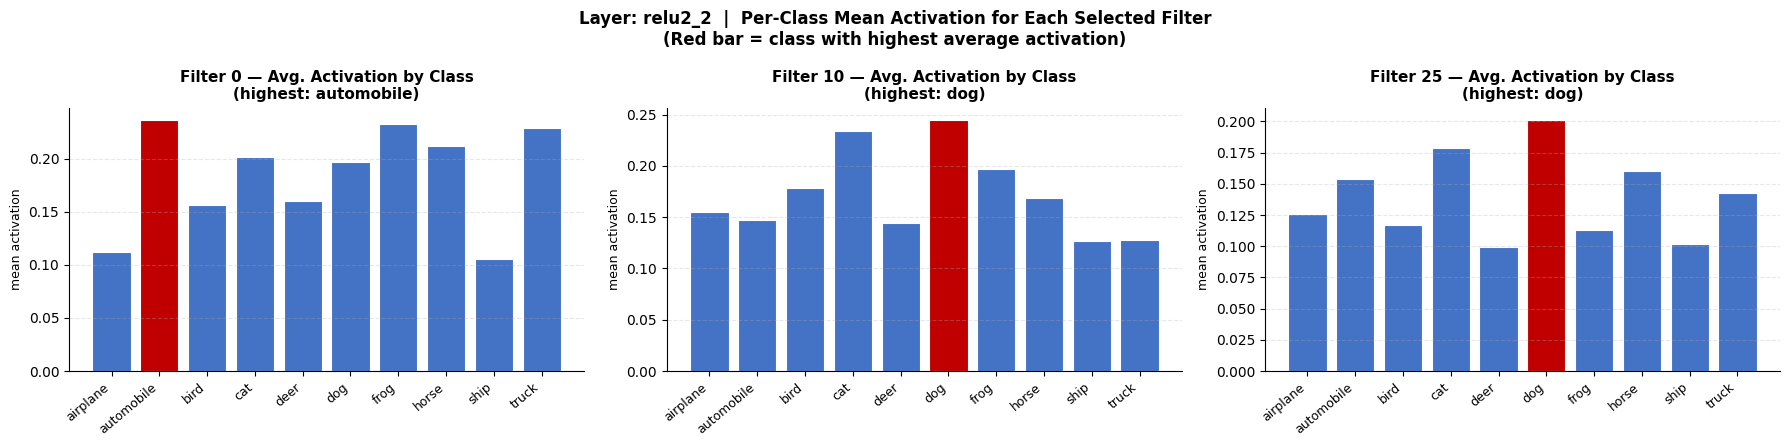

Saved: per_class_activation.png


In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4.5))

for ax, filt_idx in zip(axes, CHOSEN_FILTERS):
    filter_scores = scalar_activations[:, filt_idx]
    class_means   = [filter_scores[y_test == c].mean() for c in range(10)]
    top_cls       = int(np.argmax(class_means))

    colors = ['#4472C4'] * 10
    colors[top_cls] = '#C00000'   # highlight top class in red

    bars = ax.bar(CLASS_NAMES, class_means, color=colors, edgecolor='white', linewidth=0.8)

    ax.set_title(f'Filter {filt_idx} — Avg. Activation by Class\n(highest: {CLASS_NAMES[top_cls]})',
                 fontsize=11, fontweight='bold')
    ax.set_xticklabels(CLASS_NAMES, rotation=40, ha='right', fontsize=9)
    ax.set_ylabel(f'{ACTIVATION_METHOD} activation', fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.suptitle(
    f'Layer: {CHOSEN_LAYER}  |  Per-Class Mean Activation for Each Selected Filter\n'
    f'(Red bar = class with highest average activation)',
    fontsize=12, fontweight='bold'
)
plt.tight_layout()
plt.savefig('per_class_activation.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: per_class_activation.png')

### Step 13 — Side-by-Side Activation Score Comparison Across Filters

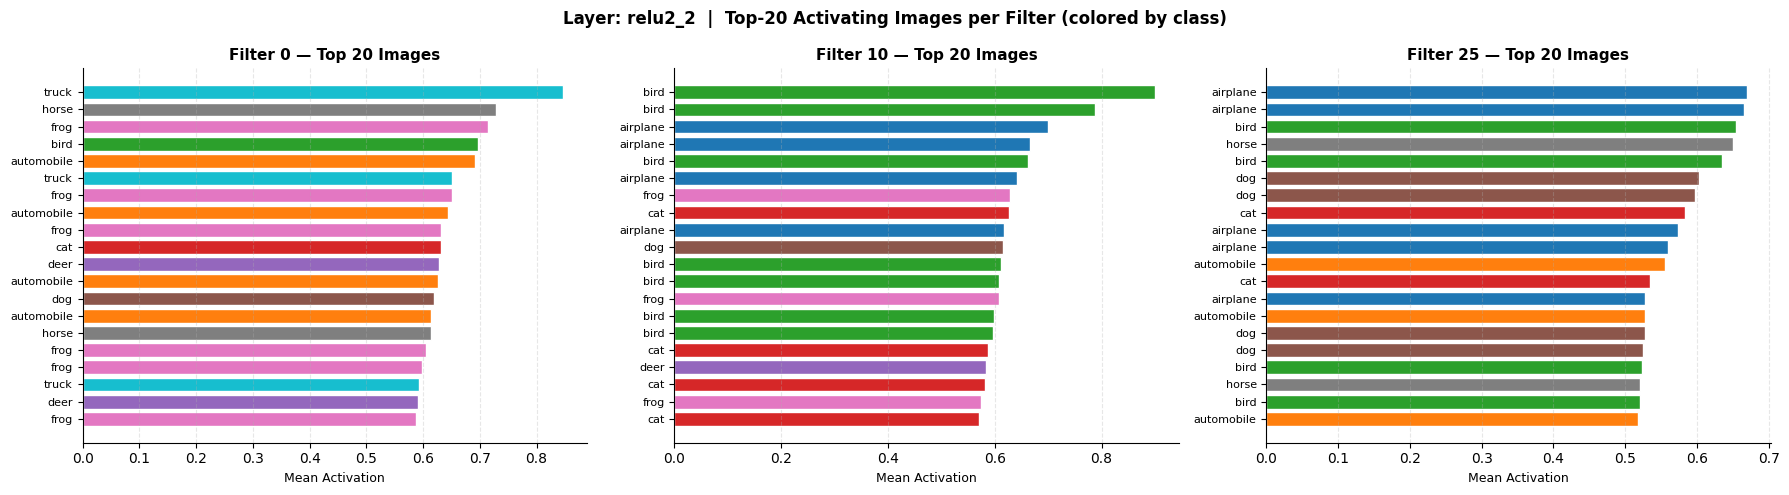

Saved: top20_activations.png


In [27]:
# Heatmap: top-20 activating images for each filter, colored by class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, filt_idx in zip(axes, CHOSEN_FILTERS):
    scores   = scalar_activations[:, filt_idx]
    top20    = np.argsort(scores)[::-1][:20]
    top_lbls = y_test[top20]
    top_scrs = scores[top20]

    cmap_colors = plt.cm.tab10(np.linspace(0, 1, 10))
    bar_colors  = [cmap_colors[l] for l in top_lbls]

    ax.barh(range(20), top_scrs[::-1], color=bar_colors[::-1], edgecolor='white')
    ax.set_yticks(range(20))
    ax.set_yticklabels([CLASS_NAMES[l] for l in top_lbls[::-1]], fontsize=8)
    ax.set_xlabel('Mean Activation', fontsize=9)
    ax.set_title(f'Filter {filt_idx} — Top 20 Images', fontsize=11, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

fig.suptitle(
    f'Layer: {CHOSEN_LAYER}  |  Top-20 Activating Images per Filter (colored by class)',
    fontsize=12, fontweight='bold'
)
plt.tight_layout()
plt.savefig('top20_activations.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: top20_activations.png')

---
## Step 14 — Save All Output Files to Google Drive

In [28]:
# Mount Google Drive and copy all output files
from google.colab import drive
import shutil, os

drive.mount('/content/drive')

SAVE_DIR = '/content/drive/MyDrive/CSCI611_Assignment2_Task2'
os.makedirs(SAVE_DIR, exist_ok=True)

output_files = [
    'selected_images.png',
    'feature_maps_airplane.png',
    'feature_maps_cat.png',
    'feature_maps_horse.png',
    'all_feature_maps_airplane.png',
    'all_feature_maps_cat.png',
    'all_feature_maps_horse.png',
    'conv1_filter_kernels.png',
    'max_activating_filter0.png',
    'max_activating_filter10.png',
    'max_activating_filter25.png',
    'per_class_activation.png',
    'top20_activations.png',
]

for fname in output_files:
    if os.path.exists(fname):
        shutil.copy(fname, os.path.join(SAVE_DIR, fname))
        print(f'Copied: {fname}')
    else:
        print(f'NOT FOUND: {fname} (may not have been generated yet)')

print(f'\nAll files saved to: {SAVE_DIR}')

Mounted at /content/drive
Copied: selected_images.png
Copied: feature_maps_airplane.png
Copied: feature_maps_cat.png
Copied: feature_maps_horse.png
Copied: all_feature_maps_airplane.png
Copied: all_feature_maps_cat.png
Copied: all_feature_maps_horse.png
Copied: conv1_filter_kernels.png
Copied: max_activating_filter0.png
Copied: max_activating_filter10.png
Copied: max_activating_filter25.png
Copied: per_class_activation.png
Copied: top20_activations.png

All files saved to: /content/drive/MyDrive/CSCI611_Assignment2_Task2


---
## Step 15 — Summary

In [29]:
print('=' * 60)
print('     TASK 2 — COMPLETE SUMMARY')
print('=' * 60)
print()
print('── Part A: Feature Maps ────────────────────────────────')
print(f'  Layer visualized : conv1_1 → relu1_1 (first conv layer)')
print(f'  Output shape     : (32, 32, 32) — 32 filters at 32×32')
print(f'  Images analyzed  : airplane, cat, horse')
print(f'  Filters shown    : 8 per image (+ all 32 in extended view)')
print()
print('── Part B: Maximally Activating Images ─────────────────')
print(f'  Layer            : {CHOSEN_LAYER}')
print(f'  Filters analyzed : {CHOSEN_FILTERS}')
print(f'  Activation metric: {ACTIVATION_METHOD} of 16×16 feature map')
print(f'  Top-K per filter : {TOP_K}')
print()
print('── Top-5 Results ───────────────────────────────────────')
for filt_idx in CHOSEN_FILTERS:
    scores  = scalar_activations[:, filt_idx]
    top5    = np.argsort(scores)[::-1][:5]
    classes = [CLASS_NAMES[y_test[i]] for i in top5]
    print(f'  Filter {filt_idx:2d}: {classes}')
print()
print('── Files Generated ─────────────────────────────────────')
for fname in output_files:
    print(f'  {fname}')
print('=' * 60)

     TASK 2 — COMPLETE SUMMARY

── Part A: Feature Maps ────────────────────────────────
  Layer visualized : conv1_1 → relu1_1 (first conv layer)
  Output shape     : (32, 32, 32) — 32 filters at 32×32
  Images analyzed  : airplane, cat, horse
  Filters shown    : 8 per image (+ all 32 in extended view)

── Part B: Maximally Activating Images ─────────────────
  Layer            : relu2_2
  Filters analyzed : [0, 10, 25]
  Activation metric: mean of 16×16 feature map
  Top-K per filter : 5

── Top-5 Results ───────────────────────────────────────
  Filter  0: ['truck', 'horse', 'frog', 'bird', 'automobile']
  Filter 10: ['bird', 'bird', 'airplane', 'airplane', 'bird']
  Filter 25: ['airplane', 'airplane', 'bird', 'horse', 'bird']

── Files Generated ─────────────────────────────────────
  selected_images.png
  feature_maps_airplane.png
  feature_maps_cat.png
  feature_maps_horse.png
  all_feature_maps_airplane.png
  all_feature_maps_cat.png
  all_feature_maps_horse.png
  conv1_filter_